In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegression

#### Load dataset used in all tasks

In [2]:
# Load the excel file
# By specifying sheet_name, we filter out the sheet 'category_data'
data = pd.read_excel('data.xlsx', sheet_name='data')
plot_colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown']

### Task 1

In [3]:
show_boxplot = True        # Whether we should show a bar-plot for the average age for each group category
p_value_treshold = 0.05   # We reject the null hypothesis if the p-value is less than 5%

#### Display Graphs showing our data

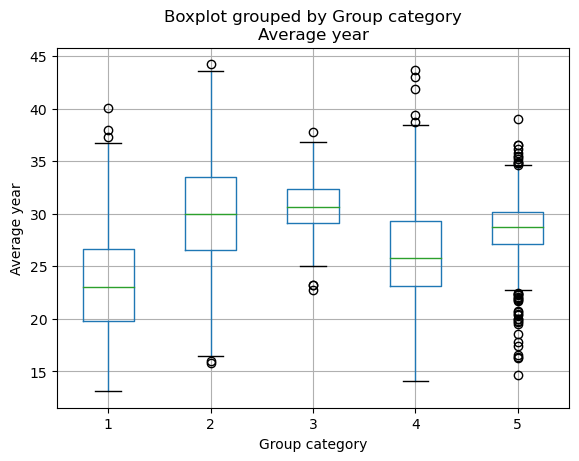

In [4]:
# Group the data by the 'Group category' column
grouped_data = data.groupby('Group category')['Average year']
grouped_means = grouped_data.mean()

# We visualize the data
if(show_boxplot):
    data.boxplot(column='Average year', by='Group category')
    plt.xlabel('Group category')
    plt.ylabel('Average year')
    plt.show()

#### Perform the one-way ANOVA

In [5]:
# We do a one-way ANOVA test
result = f_oneway(*[group_df for group_name, group_df in grouped_data])
print("After doing a one-way ANOVA test, we get the following results:")
print("The F-value of the one-way ANOVA test is: ", result.statistic)
print("The p-value of the one-way ANOVA test is: ", result.pvalue)
print("\n")
if(result.pvalue < p_value_treshold):
    print("The p-value is less than the treshold, we reject the null hypothesis")
else:
    print("The p-value is greater than the treshold, we fail to reject the null hypothesis")

After doing a one-way ANOVA test, we get the following results:
The F-value of the one-way ANOVA test is:  171.50703270711966
The p-value of the one-way ANOVA test is:  1.0820916064752822e-126


The p-value is less than the treshold, we reject the null hypothesis


### Task 2a

In [6]:
show_plot = True
decimals = 5
independent_value = 'Average year'
dependent_values = ['No-response ratio', 'Night-chat ratio', 'Picture ratio']

#### Perform linear regression


------------------------------------------------------------
Linear regression model for No-response ratio
Formula:            y = 0.01287x + 0.28629
Mean squared error: 0.03987
Correlation:        0.3105

------------------------------------------------------------
Linear regression model for Night-chat ratio
Formula:            y = -0.00907x + 0.38993
Mean squared error: 0.01394
Correlation:        -0.36276

------------------------------------------------------------
Linear regression model for Picture ratio
Formula:            y = -0.00065x + 0.04738
Mean squared error: 0.00212
Correlation:        -0.07134


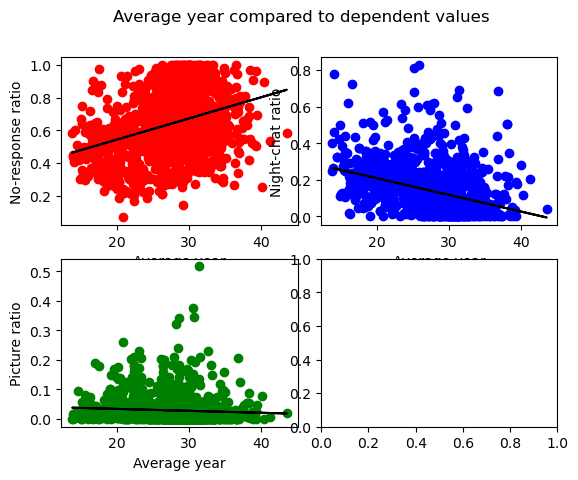

In [7]:
# We don't want any data where column 11 isn't greater than or equal to 20
filtered_data = data[data['Session number'] >= 20]

# We create subplots for each linear regrssion
fig, axs = plt.subplots(-(-len(dependent_values) // 2), 2)

# Perform linear regression against our dependent values
for column in dependent_values:
    index = dependent_values.index(column)
    this_axs = axs[index // 2][index % 2]

    x = filtered_data[independent_value].values.reshape(-1, 1)
    y = filtered_data[column].values

    # Train a linear Regression
    regressor = LinearRegression()
    regressor.fit(x, y)

    # Predict the values for the model
    y_pred = regressor.predict(x)

    # Calculate error for the model
    mse = mean_squared_error(y, y_pred)

    # We calculate the correlation between average age and the independent vales
    correlation, _ = pearsonr(filtered_data[independent_value], filtered_data[column])

    # Print information about our regression model
    print("\n------------------------------------------------------------")
    print(f"Linear regression model for {column}")
    print(f"Formula:            y = {round(regressor.coef_[0], decimals)}x + {round(regressor.intercept_, decimals)}")
    print(f"Mean squared error: {round(mse, decimals)}")
    print(f"Correlation:        {round(correlation, decimals)}")

    # Plot the data
    this_axs.scatter(x, y, color=plot_colors[index])
    this_axs.plot(x, y_pred, color='black')
    this_axs.set_xlabel(independent_value)
    this_axs.set_ylabel(column)

plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.suptitle(f'{independent_value} compared to dependent values')
plt.show()

### Task 2b

In [8]:
X = data.iloc[:, 2:10].values   # We choose Col 3-10 as our features
Y = data.iloc[:, 11:14].values  # We choose Col 12-14 as our labels

#### Perform multivariable regression

In [9]:
# The session number is used as the weights for the regression
weights = data['Session number'].values

for i in range(Y.shape[1]):
    # Fit weighted linear regression for each column using all data
    regressor = LinearRegression()
    regressor.fit(X, Y[:, i], sample_weight=weights)

    # Print the linear equation for the regression model
    print(f"\nLinear regression model for Column {12 + i}:")
    print(f"Formula: y = {' + '.join([f'{coef:.3f}*X{i+3}' for i, coef in enumerate(regressor.coef_)])} + {regressor.intercept_:.3f}")

    # Predict on the same data (since we're using all the data for training and error calculation)
    y_pred = regressor.predict(X)

    # Calculate MSE on all data
    mse = mean_squared_error(Y[:, i], y_pred)
    print(f"Mean Squared Error for Column {12 + i}: {mse:.3f}")


Linear regression model for Column 12:
Formula: y = -0.000*X3 + -0.000*X4 + -0.041*X5 + -0.021*X6 + 0.008*X7 + -0.002*X8 + -0.042*X9 + -0.186*X10 + 0.480
Mean Squared Error for Column 12: 0.065

Linear regression model for Column 13:
Formula: y = -0.000*X3 + 0.000*X4 + 0.045*X5 + 0.039*X6 + -0.008*X7 + 0.011*X8 + -0.043*X9 + 0.130*X10 + 0.280
Mean Squared Error for Column 13: 0.033

Linear regression model for Column 14:
Formula: y = -0.000*X3 + 0.000*X4 + 0.000*X5 + 0.024*X6 + -0.001*X7 + 0.000*X8 + -0.012*X9 + -0.009*X10 + 0.044
Mean Squared Error for Column 14: 0.007


### Task 2c

In [10]:
calculate_all_options = True # WARNING, will run a long calulation instead of the original one

#### We define a function using Logistic Regression to perform binary classification

In [11]:
def binary(X, Y):
    # Splitting the data into training and testing sets (80% training, 20% testing)
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2)

    # Train the model
    regressor = LogisticRegression(max_iter=1000)
    regressor.fit(X_train, Y_train)

    # Print the accuracy of the model
    return regressor.score(X_test, Y_test)

#### We use the binary classifier to estimate for the different columns

In [12]:
# Filter so we only have category 1 and 4
filtered_data = data[data['Group category'].isin([1, 4])]

# Perform a standard logistic binar classification with all columns as variables
X = filtered_data.iloc[:, 2:13].values
Y = filtered_data['Group category'].values
print(f"\n------------------------------------------------------------")
print(f"Standard Logistic Regression Model")
print(f"Accuracy: {binary(X, Y)}")

# ALTERNATIVE SOLUTION
# We take every combination of every column to find the optimal multivariable binary operator
if(calculate_all_options):
    highest_accuracy = 0
    highest_accuracy_columns = []

    # Generate all combinations of 2 or more columns
    # The first column is name and the second is the category. We don't need neither
    for r in range(2, 13):
        for combo in itertools.combinations(range(2, 13), r):
            X = filtered_data.iloc[:, list(combo)].values  # Select the columns corresponding to the current combination
            new_accuracy = binary(X, Y)  # Call your binary classification function

            # Update if a new higher accuracy is found
            if new_accuracy > highest_accuracy:
                highest_accuracy = new_accuracy
                highest_accuracy_columns = combo

    print(f"\n------------------------------------------------------------")
    print(f"Best Logistic Regression Model")
    print(f"Accuracy: {highest_accuracy}")
    print(f"Columns: {highest_accuracy_columns}")


------------------------------------------------------------
Standard Logistic Regression Model
Accuracy: 0.8241758241758241

------------------------------------------------------------
Best Logistic Regression Model
Accuracy: 0.9230769230769231
Columns: (2, 4, 5, 6, 8, 9)


### Task 3

In [13]:
decimals = 5
independent_value = 'Average year'
dependent_value = 'Night-chat ratio'

#### Sampling Strategies

In [14]:
def sample_random(data, index):
    return np.array_split(data, index)

def sample_stratified(data, index, chosen_strata = 'Message number'):
    fraction = 1 / index  # Fraction for each strata
    filtered_data = data.copy()
    
    # Create strata based on quantiles
    filtered_data['strata'] = pd.qcut(filtered_data[chosen_strata], 4, labels=False)
    
    # Sample each strata with fraction and reset index
    sample = filtered_data.groupby('strata').apply(lambda x: x.sample(frac=fraction, random_state=42)).reset_index(drop=True)
    return np.array_split(sample, index)

def sample_systematic(data, index):
    step = int(len(data) / index)
    sample = data.iloc[::step] 
    return np.array_split(sample, index) 

#### Linear Regression function

In [15]:
def linreg(data, sampling, samples=10):
    regressors = []
    means = []
    std_devs = []
    
    # Split the data into equal parts
    data_chunks = sampling(data, samples)
    
    for index, chunk in enumerate(data_chunks):
        x = chunk[independent_value].values.reshape(-1, 1)
        y = chunk[dependent_value].values

        # Calculate mean and standard deviation for each chunk and add to list
        means.append(np.mean(y))
        std_devs.append(np.std(y))

        # Create a linear regression model
        regressor = LinearRegression()
        regressor.fit(x, y)

        # Add the regressor to the list
        regressors.append(regressor)
    
    # Create our average linear regression
    average_regressor = LinearRegression()
    average_regressor.coef_ = np.mean([regressor.coef_ for regressor in regressors], axis=0)
    average_regressor.intercept_ = np.mean([regressor.intercept_ for regressor in regressors], axis=0)
    
    # Calculate the MSE value for the regression
    x_full = data[independent_value].values.reshape(-1, 1)  # Full dataset's independent variable
    y_full = data[dependent_value].values                   # Full dataset's dependent variable
    y_pred_full = average_regressor.predict(x_full)
    mse = mean_squared_error(y_full, y_pred_full)
    
    # Create a DataFrame for means and standard deviations, which we use to display them better later on
    stats_df = pd.DataFrame({
        'Chunk': range(1, samples + 1),
        'Mean': np.round(means, decimals),
        'S. Deviation': np.round(std_devs, decimals)
    })
    
    return average_regressor, mse, stats_df


#### Make 10 linear regressions, average these and display the resulting mean regression


------------------------------------------------------------
Random linear regression
Formula:            y = -0.00721x + 0.33879
Mean squared error: 0.01403
Plot color:         black

Statistics for Random sampling:
   Chunk     Mean  S. Deviation
0      1  0.18737       0.13135
1      2  0.21702       0.13584
2      3  0.15447       0.12664
3      4  0.10312       0.10837
4      5  0.13020       0.12027
5      6  0.17595       0.13745
6      7  0.12751       0.13708
7      8  0.09474       0.10127
8      9  0.10492       0.09961
9     10  0.11087       0.09573

------------------------------------------------------------
Stratified linear regression
Formula:            y = -0.01019x + 0.42146
Mean squared error: 0.01397
Plot color:         gray

Statistics for Stratified sampling:
   Chunk     Mean  S. Deviation
0      1  0.19719       0.16748
1      2  0.12999       0.14617
2      3  0.05365       0.06942
3      4  0.09623       0.07278
4      5  0.11955       0.10987
5      6  0.1

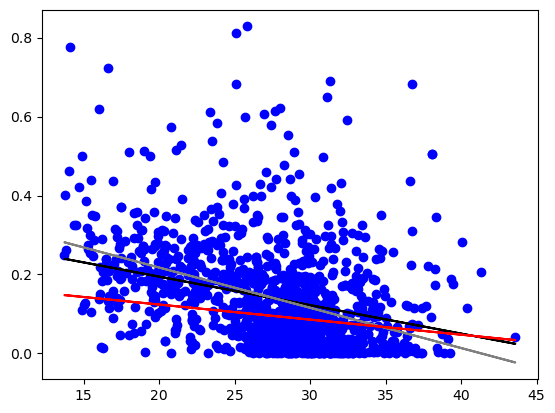

In [16]:
# Settings
sampling_strats = [sample_random, sample_stratified, sample_systematic]
sampling_strats_names = ['Random', 'Stratified', 'Systematic']
regressor_colors = ['black', 'gray', 'red']

# I assume we will still filter out data where there is is less than 20 messages
filtered_data = data[data['Session number'] >= 20]

# We do a scatterplot of the filtered data
plt.scatter(filtered_data[independent_value], filtered_data[dependent_value], color='blue')

# Test out the different sampling strategies
for index, strategy in enumerate(sampling_strats):

    # Estimate the regressor using our strategy and calculate mean/std
    average_regressor, regressor_error, stats_df = linreg(filtered_data, strategy, 10)
    
    # Plot the information about our regression
    print("\n------------------------------------------------------------")
    print(f"{sampling_strats_names[index]} linear regression")
    print(f"Formula:            y = {round(average_regressor.coef_[0], decimals)}x + {round(average_regressor.intercept_, decimals)}")
    print(f"Mean squared error: {round(regressor_error, decimals)}")
    print(f"Plot color:         {regressor_colors[index]}")
    
    # Display the table of mean and standard deviation
    print(f"\nStatistics for {sampling_strats_names[index]} sampling:")
    print(stats_df)

    # Plot the regression line
    x = filtered_data[independent_value].values.reshape(-1, 1)
    plt.plot(x, average_regressor.predict(x), color=regressor_colors[index])

plt.show()


NameError: name 'matrix' is not defined